In [1]:
#importing all the libraries
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import plot_importance  
from sklearn import svm
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve

## Loading the data

In [2]:
df = pd.read_csv("European_bank_marketing.csv")

## Checking null values

In [7]:
df.isnull().sum()

age                  0
job                  0
marital              0
education            0
default              0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
term_deposit         0
Ethnicity_African    0
job2                 0
marital2             0
education2           0
default2             0
housing2             0
loan2                0
contact2             0
month2               0
day_of_week2         0
poutcome2            0
dtype: int64

There are no "Null" values, so we don't have to work on ways to replace values.

In [23]:
print(f'The dataset has {len(df)} records from past telemarketing campaigns.')
print(f'Each record has {df.shape[1]-1} features and the last column in the dataframe indicates the binary outcome of the campaign (subscribed or not subscribed).')

The dataset has 41188 records from past telemarketing campaigns.
Each record has 31 features and the last column in the dataframe indicates the binary outcome of the campaign (subscribed or not subscribed).


# Converting categorical data into numerical values

In [24]:
cols = ['age', 'job2', 'marital2', 'education2', 'default2', 'housing2', 'loan2', 'contact2', 'month2', 'day_of_week2',\
        'campaign', 'pdays', 'previous', 'poutcome2', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', \
        'euribor3m', 'nr.employed', 'term_deposit','Ethnicity_African']


df['job2'] = df.job.factorize()[0]
df['marital2'] = df.marital.factorize()[0]
df['education2'] = df.education.factorize()[0]
df['default2'] = df.default.factorize()[0]
df['housing2'] = df.housing.factorize()[0]
df['loan2'] = df.loan.factorize()[0]
df['contact2'] = df.contact.factorize()[0]
df['month2'] = df.month.factorize()[0]
df['day_of_week2'] = df.day_of_week.factorize()[0]
df['poutcome2'] = df.poutcome.factorize()[0]

We removed the duration column, which provided the customer's most recent call duration in seconds. This feature has a significant impact on the target variable (Term deposit = 1) because it makes sense that a customer who has been successfully converted would talk to the agent about the investment details for a longer period of time than a customer who is not interested.

# Separating the x and y part of the data

In [25]:
cols1 = ['age', 'job2', 'marital2', 'education2', 'default2', 'housing2', 'loan2', 'contact2', 'month2', 'day_of_week2',\
        'campaign', 'pdays', 'previous', 'poutcome2', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', \
        'euribor3m', 'nr.employed','Ethnicity_African']
xaxis = df2[cols1]
yaxis = df2['term_deposit']
xaxis.head()

,age,job2,marital2,education2,default2,housing2,loan2,contact2,month2,day_of_week2,campaign,pdays,previous,poutcome2,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Ethnicity_African
0,56,0,0,0,0,0,0,0,0,0,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,1,0,1,1,0,0,0,0,0,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,1,0,1,0,1,0,0,0,0,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,2,0,2,0,0,0,0,0,0,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,1,0,1,0,0,1,0,0,0,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0


In [26]:
print("Data Type: ")
print('Not Agreed for Term Deposit ', yaxis.value_counts()[0],"- ", round(yaxis.value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Agreed for Term Deposit ',yaxis.value_counts()[1] ,"-",round(yaxis.value_counts()[1]/len(df) * 100,2), '% of the dataset')

Data Type: 
Not Agreed for Term Deposit  34875 -  84.67 % of the dataset
Agreed for Term Deposit  4607 - 11.19 % of the dataset


<AxesSubplot:title={'center':'Bar Graph of 0 and 1 in Class column'}, xlabel='Term Deposit Status', ylabel='No. of People'>

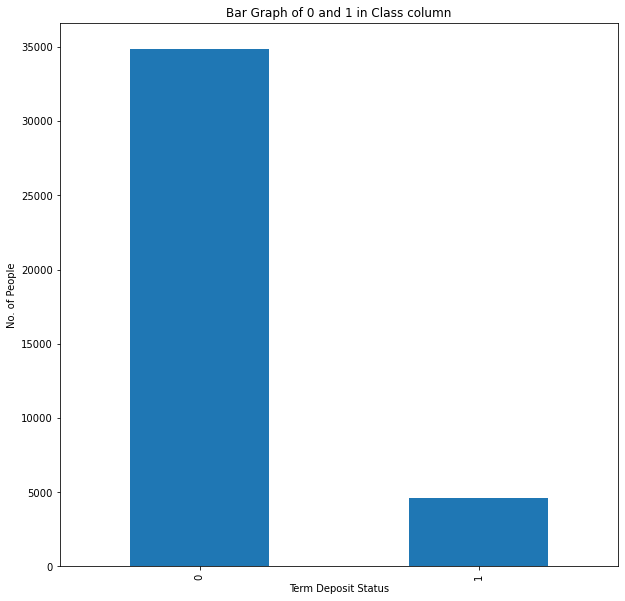

In [27]:
yaxis.value_counts().plot(kind='bar', figsize = (10,10),xlabel = 'Term Deposit Status',ylabel = 'No. of People', title = 'Bar Graph of 0 and 1 in Class column')

Note: Notice how imbalanced is our original dataset! Most of the calls are belong to non-term deposit. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most calls are for selecting non-term deposit. But we don't want our model to assume, we want our model to detect patterns that give signs for selecting term deposit!

# Functions to plot ROC Curve and Precision Recall Curve

In [28]:
def plot_roc_curve(false_positive_rate,true_positive_rate,roc_auc):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
    plt.plot([0,1],[0,1], linewidth=5)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='upper right')
    plt.title('Receiver operating characteristic curve (ROC)')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
# Define a precision_recall_curve function
def plot_pr_curve(recall, precision, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()


# Splitting Test and Train Data

In [29]:
x_train, x_test, y_train, y_test = train_test_split(xaxis, yaxis, test_size=.3, random_state=0)

# Turn into an array
xtrain = x_train.values
xtest = x_test.values
ytrain = y_train.values
ytest = y_test.values

# Fitting Logistic Regression to the training dataset

AUC of the predictions: 0.6093589570492431
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.94     10442
           1       0.71      0.23      0.35      1403

    accuracy                           0.90     11845
   macro avg       0.81      0.61      0.65     11845
weighted avg       0.88      0.90      0.87     11845

Confusion matrix:
 [[10307   135]
 [ 1078   325]]


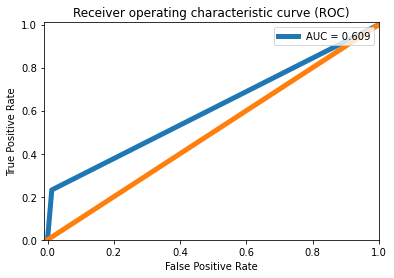

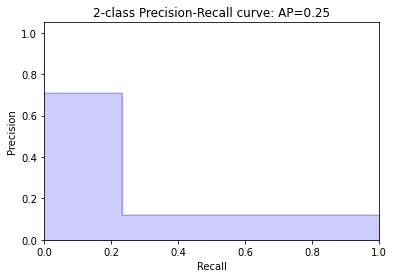

In [30]:
# Fit a logistic regression model to training and test
model = LogisticRegression(solver='lbfgs', max_iter=2000)
model.fit(xtrain, ytrain)

# Obtain model predictions
y_predicted = model.predict(xtest)

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(ytest, y_predicted)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
#roc_auc_score(ytest, probs[:, 1])
# print('ROC AUC Score:',roc_auc)

print("AUC of the predictions: {0}".format(metrics.auc(false_positive_rate, true_positive_rate)))

# Obtain precision and recall 
precision, recall, thresholds = precision_recall_curve(ytest, y_predicted)

# Calculate average precision 
average_precision = average_precision_score(ytest, y_predicted)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(ytest, y_predicted))
print('Confusion matrix:\n',confusion_matrix(y_true = ytest, y_pred = y_predicted))

# Plot the roc curve 
plot_roc_curve(false_positive_rate,true_positive_rate,roc_auc)

# Plot recall precision curve
plot_pr_curve(recall, precision, average_precision)


Text(0.5, 0.98, 'Impact of threshold adjustment on the error matrix')

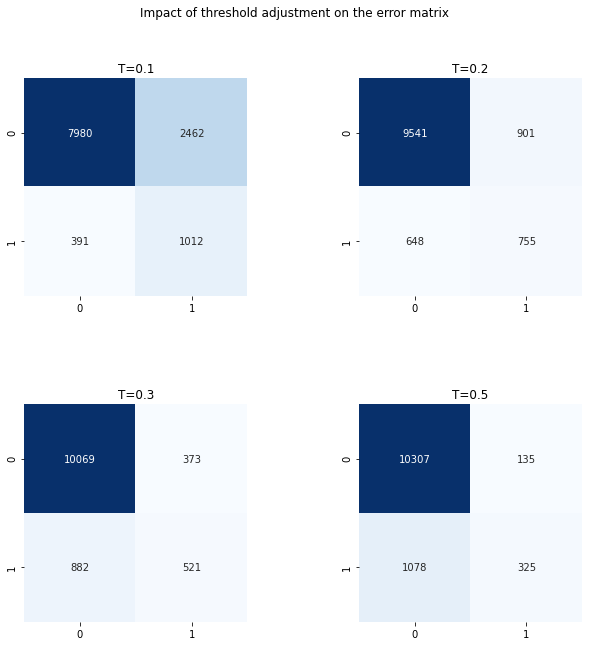

In [31]:
y_pred = model.predict_proba(xtest)[:,1]

fig, axes = plt.subplots(2,2, figsize=(10,10))

th_values = [10, 20, 35, 50]

for t, ax in enumerate(axes.flat):
    threshold = th_values[t]/100
    y_pred_int = (y_pred > threshold).astype(int)
    c_matrix = confusion_matrix(y_true = ytest, y_pred = y_pred_int)
    sns.heatmap(c_matrix, annot=True, cmap="Blues", fmt="d", ax=ax, cbar=False)
    ax.title.set_text("T=%.1f" % threshold)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the error matrix")

We used 4 threshold values to make the confusion matrix but generally the preference is given to 0.5 threshold. It is evident the model is predicting well the calls of non term deposit status. It doesn't mean that the model is performing well. 

# Applying Tree Based Models

### Decision Trees

AUC of the predictions: 0.6093589570492431
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.94     10442
           1       0.71      0.23      0.35      1403

    accuracy                           0.90     11845
   macro avg       0.81      0.61      0.65     11845
weighted avg       0.88      0.90      0.87     11845

Confusion matrix:
 [[10307   135]
 [ 1078   325]]


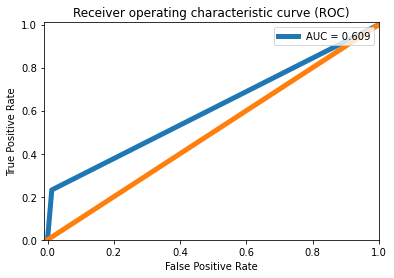

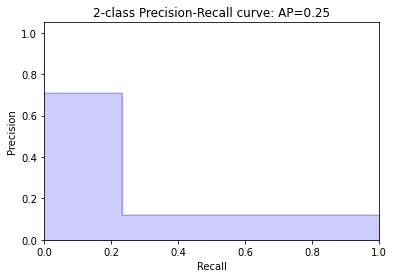

In [40]:
# Fit a decision tree model to training and test
classifier=DecisionTreeClassifier(random_state = 42,criterion='entropy')
classifier.fit(xtrain,ytrain)

# Obtain model predictions
y_predicted = model.predict(xtest)

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(ytest, y_predicted)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
#roc_auc_score(ytest, probs[:, 1])
# print('ROC AUC Score:',roc_auc)

print("AUC of the predictions: {0}".format(metrics.auc(false_positive_rate, true_positive_rate)))

# Obtain precision and recall 
precision, recall, thresholds = precision_recall_curve(ytest, y_predicted)

# Calculate average precision 
average_precision = average_precision_score(ytest, y_predicted)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(ytest, y_predicted))
print('Confusion matrix:\n',confusion_matrix(y_true = ytest, y_pred = y_predicted))

# Plot the roc curve 
plot_roc_curve(false_positive_rate,true_positive_rate,roc_auc)

# Plot recall precision curve
plot_pr_curve(recall, precision, average_precision)


### Random Forest

AUC of the predictions: 0.641383630420653
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94     10442
           1       0.62      0.31      0.41      1403

    accuracy                           0.90     11845
   macro avg       0.76      0.64      0.68     11845
weighted avg       0.88      0.90      0.88     11845

Confusion matrix:
 [[10172   270]
 [  970   433]]


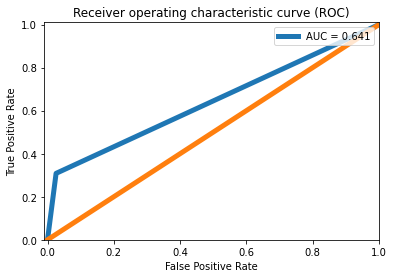

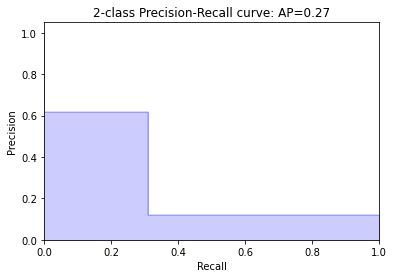

In [42]:
# Fit a random forest model to training and test
randomclassifier=RandomForestClassifier(n_estimators=200,criterion='entropy')

randomclassifier.fit(xtrain,ytrain)

# Obtain model predictions
y_predicted = randomclassifier.predict(xtest)

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(ytest, y_predicted)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
#roc_auc_score(ytest, probs[:, 1])
# print('ROC AUC Score:',roc_auc)

print("AUC of the predictions: {0}".format(metrics.auc(false_positive_rate, true_positive_rate)))

# Obtain precision and recall 
precision, recall, thresholds = precision_recall_curve(ytest, y_predicted)

# Calculate average precision 
average_precision = average_precision_score(ytest, y_predicted)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(ytest, y_predicted))
print('Confusion matrix:\n',confusion_matrix(y_true = ytest, y_pred = y_predicted))

# Plot the roc curve 
plot_roc_curve(false_positive_rate,true_positive_rate,roc_auc)

# Plot recall precision curve
plot_pr_curve(recall, precision, average_precision)


### Bagging - Ensemble Method

AUC of the predictions: 0.6271755614934642
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94     10442
           1       0.54      0.29      0.38      1403

    accuracy                           0.89     11845
   macro avg       0.73      0.63      0.66     11845
weighted avg       0.87      0.89      0.87     11845

Confusion matrix:
 [[10106   336]
 [ 1001   402]]


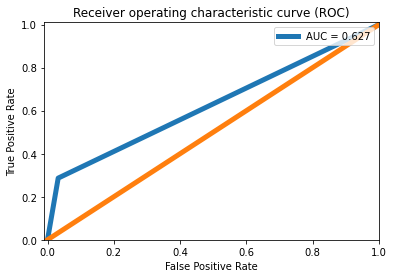

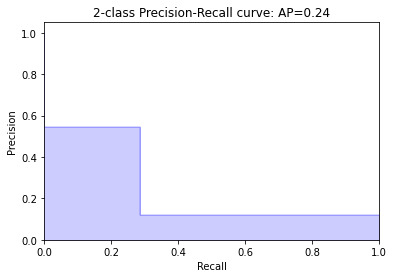

In [46]:
# Fit the bagging classifier
bgclassifier = BaggingClassifier()

bgclassifier.fit(xtrain, ytrain)

# Obtain model predictions
y_predicted = bgclassifier.predict(xtest)

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(ytest, y_predicted)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
#roc_auc_score(ytest, probs[:, 1])
# print('ROC AUC Score:',roc_auc)

print("AUC of the predictions: {0}".format(metrics.auc(false_positive_rate, true_positive_rate)))

# Obtain precision and recall 
precision, recall, thresholds = precision_recall_curve(ytest, y_predicted)

# Calculate average precision 
average_precision = average_precision_score(ytest, y_predicted)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(ytest, y_predicted))
print('Confusion matrix:\n',confusion_matrix(y_true = ytest, y_pred = y_predicted))

# Plot the roc curve 
plot_roc_curve(false_positive_rate,true_positive_rate,roc_auc)

# Plot recall precision curve
plot_pr_curve(recall, precision, average_precision)


We can see that from the tree based models, Random forest have the best AUC i.e 0.6413

# Plot Feature Importance

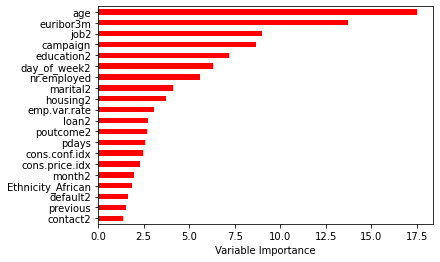

In [30]:
Importance = pd.DataFrame({'Importance':randomclassifier.feature_importances_*100}, index=xaxis.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

We can see that 'Age' is the most crucial feature in the model's forecast.

# Applying SVM to training and test data

In [44]:
# Fit SVM to our data
model = svm.SVC(C= 1, kernel= 'linear', random_state= 0, probability=True)
model.fit(xtrain, ytrain)

# Obtain model predictions
y_predicted = model.predict(xtest)

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(ytest, y_predicted)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
#roc_auc_score(ytest, probs[:, 1])
# print('ROC AUC Score:',roc_auc)
print("AUC of the predictions: {0}".format(metrics.auc(false_positive_rate, true_positive_rate)))


# Obtain precision and recall 
precision, recall, thresholds = precision_recall_curve(ytest, y_predicted)

# Calculate average precision 
average_precision = average_precision_score(ytest, y_predicted)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(ytest, y_predicted))
print('Confusion matrix:\n',confusion_matrix(y_true = ytest, y_pred = y_predicted))

AUC of the predictions: 0.5836462771719506
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94     10442
           1       0.63      0.18      0.28      1403

    accuracy                           0.89     11845
   macro avg       0.76      0.58      0.61     11845
weighted avg       0.87      0.89      0.86     11845

Confusion matrix:
 [[10291   151]
 [ 1148   255]]


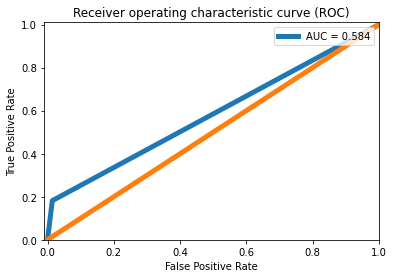

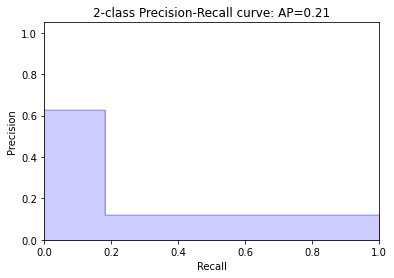

In [45]:
# Plot the roc curve 
plot_roc_curve(false_positive_rate, true_positive_rate, roc_auc)

# Plot recall precision curve
plot_pr_curve(recall, precision, average_precision)

Summary:

Random forest classifier has higher AUC values than all the other models employed for predictions. (We will further analyze Random forest classifier)

It is clear from the model performance as a whole that they are highly accurate at predicting the status of non-term deposit calls. Because of the data's extreme imbalance, accuracy is not the appropriate metric here. This explains why the model struggles to accurately predict the call status of term deposits. In order for our model to be more accurate in predicting the status of the term deposit call, we must use various approaches to balance the data. Instead of accuracy, the performance of the balanced data set model will be highlighted by the f1-score.

Resampling is a widely used approach for coping with very imbalanced datasets. It entails eliminating samples from the majority class and/or adding more examples from the minority class (under-sampling) (over-sampling). In order to tackle the problem of imbalanced data, Random Under Sampling and Over Sampling using SMOTE are applied.

# Random Under Sampling

Random Under Sampling is the process of removing random data from the majority class in order to create a more balanced dataset and avoid overfitting in our models.

● The first step is to figure out how unbalanced the class is (apply "value counts()" on the class column to figure out how much each label is worth).

● Once the responses of term deposit (term_deposit= "1") are determined, the aim is to bring the response of no term deposit to the same amount as term deposit (assuming we want a 50/50 ratio), this will be equivalent to 4607 responses of term deposit and 4607 cases of no term deposit.

● After implementing this technique, it gives us a sub-sample of a data frame with a 50/50 ratio with regards to the classes.

In [53]:
count_class_0, count_class_1 = df2.term_deposit.value_counts()

# Divide by class
df_class_0 = df2[df2['term_deposit'] == 0]
df_class_1 = df2[df2['term_deposit'] == 1]

In [54]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.term_deposit.value_counts())

Random under-sampling:
0    4607
1    4607
Name: term_deposit, dtype: int64


In [55]:
X = df_test_under.drop('term_deposit',axis='columns')
y = df_test_under['term_deposit']

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=15, stratify=y)


In [56]:
ytrain.value_counts()

1    3225
0    3224
Name: term_deposit, dtype: int64

In [60]:
# Fit Randon Forest to the Undersampled data
randomclassifier=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier.fit(xtrain,ytrain)

#obtain model predictions
predictions4 = randomclassifier.predict(xtest)

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(ytest, predictions4)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
#roc_auc_score(ytest, probs[:, 1])
# print('ROC AUC Score:',roc_auc)
print("AUC of the predictions: {0}".format(metrics.auc(false_positive_rate, true_positive_rate)))


# Obtain precision and recall 
precision, recall, thresholds = precision_recall_curve(ytest, predictions4)

# Calculate average precision 
average_precision = average_precision_score(ytest, predictions4)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(ytest, predictions4))
print('Confusion matrix:\n',confusion_matrix(y_true = ytest, y_pred = predictions4))

AUC of the predictions: 0.7309025870268812
Classification report:
               precision    recall  f1-score   support

           0       0.71      0.79      0.74      1383
           1       0.76      0.68      0.72      1382

    accuracy                           0.73      2765
   macro avg       0.73      0.73      0.73      2765
weighted avg       0.73      0.73      0.73      2765

Confusion matrix:
 [[1086  297]
 [ 447  935]]


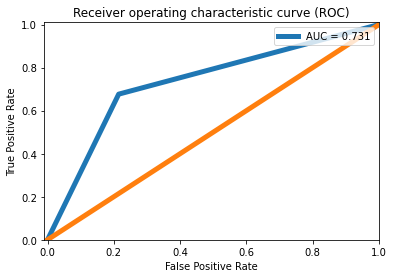

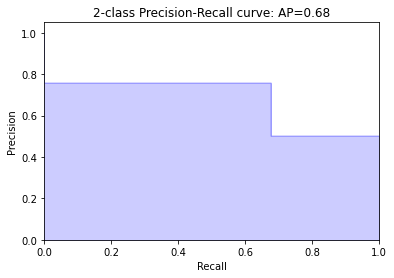

In [61]:
# Plot the roc curve 
plot_roc_curve(false_positive_rate, true_positive_rate, roc_auc)

# Plot recall precision curve
plot_pr_curve(recall, precision, average_precision)

The main issue with "Random Under-Sampling" is that the classification models will not perform as accurate as they would since there is a great deal of information loss (bringing no term deposit response to 4607 from 34,875)

Random Under Sampling increased the f1 score of minority class 1 from 0.41 to 0.72 but the f1 score for majority class reduced to 0.74 from 0.94. The classifier performed better in classifying both the classes.

# Over Sampling SMOTE

SMOTE (Synthetic Minority Oversampling Technique) is a technique for creating elements for the minority class from existing ones. It operates by picking a point from the minority class at random and computing its k-nearest neighbours. Between the specified point and its neighbours, synthetic points are added. The ratio='minority' is used to resample the minority class. In order to implement this technique, the response of term deposit should be equivalent to the response as no term deposit (assuming we want a 50/50 ratio), this will be equivalent to 34875 responses each for both term deposit and no term deposit.

In [62]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(xaxis, yaxis)

y_sm.value_counts()

0    34875
1    34875
Name: term_deposit, dtype: int64

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

In [64]:
# Number of classes in training Data
y_train.value_counts()

0    27900
1    27900
Name: term_deposit, dtype: int64

AUC of the predictions: 0.9110394265232976
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      6975
           1       0.91      0.91      0.91      6975

    accuracy                           0.91     13950
   macro avg       0.91      0.91      0.91     13950
weighted avg       0.91      0.91      0.91     13950

Confusion matrix:
 [[6350  625]
 [ 616 6359]]


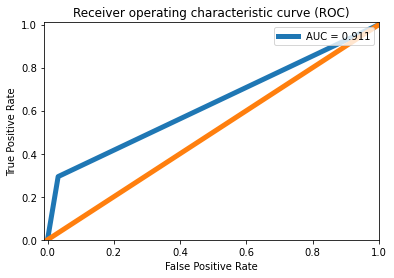

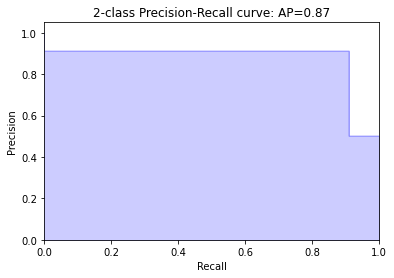

In [66]:
#Fit random classifier to the oversampled data
randomclassifier=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier.fit(X_train,y_train)

#obtain model predictions
predictions5 = randomclassifier.predict(X_test)

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, predictions5)

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
#roc_auc_score(ytest, probs[:, 1])
# print('ROC AUC Score:',roc_auc)
print("AUC of the predictions: {0}".format(metrics.auc(false_positive_rate, true_positive_rate)))


# Obtain precision and recall 
precision, recall, thresholds = precision_recall_curve(y_test, predictions5)

# Calculate average precision 
average_precision = average_precision_score(y_test, predictions5)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predictions5))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test, y_pred = predictions5))

# Plot the roc curve 
plot_roc_curve(fpr, tpr, roc_auc)

# Plot recall precision curve
plot_pr_curve(recall, precision, average_precision)

Over Sampling using SMOTE increased the f1 score of minority class 1 from 0.41 to 0.91 but the f1 score for majority class reduced to 0.91 from 0.94. This classifier not only performed better in classifying both the classes but also increased the accuracy from 0.89 to 0.91. Hence, performing better than the under sampling technique. Furthermore, it increases the overall AUC of the Random Forest model to 91.1% i.e., the best AUC score achieved among all the models.

# Conclusion

When the number of samples in each class is roughly equal, most machine learning methods operate well. Because most algorithms are designed to enhance accuracy while minimising errors. However, if the data set is unbalanced, you can achieve a high level of accuracy simply by predicting the majority class(term deposit = 0), but you will miss the minority class(term
deposit = 1), which is frequently the goal of the model in the first place.

Implementing SMOTE on our imbalanced dataset helped us with the imbalance of our labels and gave better model predictions. Nevertheless, I still have to state that sometimes the neural network or other models on the oversampled dataset predicts less correct fraud transactions than our model using the undersample dataset. The next step of this analysis will be to do an outlier removal on our oversample dataset and undersample dataset and see if our accuracy in the test set improves.